<a href="https://colab.research.google.com/github/jrw22/topic-clustering/blob/main/BERTopic-social-media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling with BERTopic 🎯

BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. [See documentation here](https://maartengr.github.io/BERTopic/index.html).

Text data is converted into embeddings that capture the contextual relationships between words. These embeddings, derived from a pre-trained BERT language model, encode rich semantic information about the text.

The embeddings then undergo dimensionality reduction, a process that helps in clustering similar documents more efficiently while preserving their semantic structure. The embeddings are then clustered using an algorithm such as HDBSCAN, which groups documents into topics based on their semantic similarity.

Each cluster or group of documents represents a potential topic, allowing for the extraction of meaningful themes from the text data. Finally, BERTopic employs a class-based TF-IDF metric to identify the most representative words of each topic, thereby creating a descriptive label for each identified topic.

By utilising advanced techniques in natural language processing and machine learning, BERTopic offers a more nuanced and contextually relevant approach to topic modeling compared to traditional methods. This enables users to extract deeper insights and uncover hidden patterns within their text datasets.

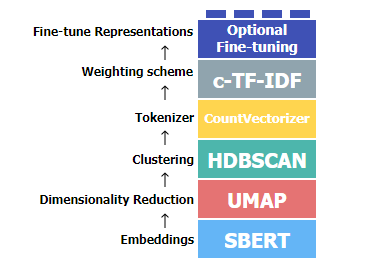...

The graphic above is used to illustrate the modularity of BERTopic and is helpful to communicate the sequence of steps taken. Because the pipeline is modular by design, the actual methods and algorithms used can be adapted to the current state-of-the-art.

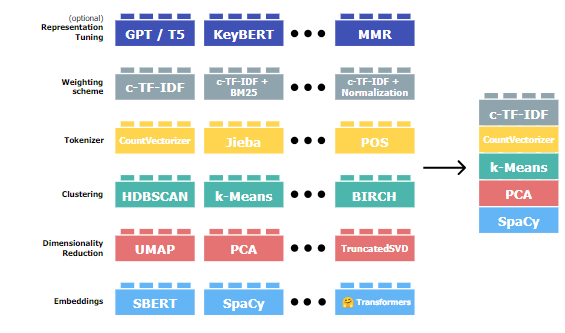


## Setup

Install and import neccessary libraries.

In [ ]:
%%capture
!pip install bertopic openai sentence-transformers langchain pymupdf

In [ ]:
# Standard library imports
from pathlib import Path
import re
import requests
from typing import List
import textwrap
from urllib.parse import urlparse

import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from google.colab import userdata
from bertopic import BERTopic
from langchain_community.document_loaders import PyMuPDFLoader
from tqdm import tqdm

# Download NLTK tokeniser
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Loading and Preparation#

In [ ]:
# Function to download a single file
def download_file(url: str, file_path: Path) -> None:
    """
    Downloads a file from the specified URL.

    Args:
        * url (`str`): URL of the file to download.
        * file_path (`Path`): The Path object for the file where it will be saved.

    Downloads the file from the URL into the specified file path.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises HTTPError if the HTTP request returned an unsuccessful status code

        with open(file_path, "wb") as file:
            file.write(response.content)

    except requests.HTTPError as e:
        print(f"HTTP Error occurred: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Function to extract text from a single PDF file
def extract_content_from_pdf(pdf_path: Path) -> str:
    """
    Extracts text from a PDF file.

    Args:
        * pdf_path (`Path`): Path to the PDF file.

    Returns:
        * `str`: Text extracted from the PDF.
    """
    return PyMuPDFLoader(str(pdf_path)).load()

def extract_text_from_doc(doc)->str:
  """
  Extracts text content from a document object.

  Args:
    * doc: Document object

  Returns:
    * combined_text (`str`): a single string of the extracted text.
  """
  # Initialise an empty string to store the combined page content
  combined_text = ""
  # Iterate over each document in the list
  for document in document_content:
      # Extract the page content from the document
      page_content = document.page_content
      # Append the page content to the combined text
      combined_text += page_content.strip() + "\n"  # Add a newline for separation if needed

  return combined_text

For this example, we're going to use the [high-level view of Basel III reforms (BIS, 2017)](https://www.bis.org/bcbs/publ/d424_hlsummary.pdf).

In [ ]:
# URL of the PDF document to download
url = "https://www.bis.org/bcbs/publ/d424_hlsummary.pdf"
# Define the file path to save the downloaded PDF
pdf_path = Path.cwd() / "document.pdf"

# Download the PDF document
download_file(url, pdf_path)
# Extract content from the downloaded PDF
document_content = extract_content_from_pdf(pdf_path)
# Extract text from the downloaded PDF
combined_text = extract_text_from_doc(document_content)
# Sentencise the document
sentences = sent_tokenize(combined_text) # NLTK tokeniser

## Create sentence embeddings

Create sentence embeddings from the document text

In [ ]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(sentences, show_progress_bar=True)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

## Dimensionality reduction

To reduce the size of the embeddings we can use a dimensionality reduction technique such as UMAP (Uniform Manifold Approximation & Projection).



In [ ]:
"""
UMAP parameters

* n_neighbours: how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. As n_neighbors increases further more and more focus in placed on the overall structure of the data. This results in, with n_neighbors=200, a plot where the overall structure is well captured, but at the loss of some of the finer local structure.
* n_components: number of dimensions of the reduced dimension space.
* min_dist: minimum distance points are allowed to be in the reduced dimensional space. Low values will result in clumpier embeddings, useful for clustering.
* metric: method for computing distance between points
* random_state: by default, UMAP shows stochastic behaviour but we can avoid this by specifying the random state.
"""

umap_model = UMAP(n_neighbors=8, n_components=5, min_dist=0, metric='cosine', random_state=42)

## Clustering

A hierarchical clustering algorithm HDBSCAN is used to cluster the embeddings in the reduced dimensions.

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

## Tokeniser

Using the CountVectorizer method from sci-kit learn.

In [ ]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

## Create topics

---



In creating the topics, we can finetune the embedding model to extract different representations of topics. The representation models used in this example are described below:

* KeyBERT - finds subphrases in a document that best represent the document itself, using BERT-embeddings and cosine similarity.
* Part-of-Speech (POS) - generates new candidate keywords for each topic based on existing documents that contain a keyword.
* Marginal Maximal Relevance (MMR) - aims to maximise diversity of keywords and phrases by considering the similarity of keywords and phrases within a document.
* OpenAI GPT-4 - using prompting to produce a short topic description based on aleady identified key words and phrases.

In [ ]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-4
prompt = """
I have a topic that is described by the following keywords: [KEYWORDS]. These keywords have been extracted from key sentences within a financial document.

Based on the information above, extract a short but highly descriptive topic label of at most 6 words. Make sure it is in the following format:
topic: <topic label>
"""
client = openai.OpenAI(api_key=userdata.get("OpenAI2"))
openai_model = OpenAI(client, model="gpt-4", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "OpenAI": openai_model,
    "MMR": mmr_model,
    "POS": pos_model
}

In [ ]:
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=20,
  verbose=True,
  calculate_probabilities=True
)

topics, probs = topic_model.fit_transform(sentences, embeddings)

2024-04-29 11:09:51,736 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-29 11:09:52,624 - BERTopic - Dimensionality - Completed ✓
2024-04-29 11:09:52,627 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-29 11:09:52,640 - BERTopic - Cluster - Completed ✓
2024-04-29 11:09:52,645 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 9/9 [00:08<00:00,  1.04it/s]
2024-04-29 11:10:02,722 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs
0,-1,20,-1_january_floor_revised_output,"[january, floor, revised, output, output floor...","[date revised, bank rwas, risk framework, cred...",[Revised Basel Approach for Risk Management],"[revised, output floor, basel, committee, risk...","[floor, output, approach, framework, standardi...",[Jurisdictions are free to apply the revised \...
1,0,22,0_cva_risk_standardised_approach,"[cva, risk, standardised, approach, standardis...","[risk standardised, cva risk, credit risk, ris...",[Standardised Approach for Calculating CVA Risk],"[cva, standardised approach, credit risk, cva ...","[risk, standardised, approach, standardised ap...",[• \nMarket risk: the standardised (or simplif...
2,1,17,1_risk_iii_iii reforms_leverage,"[risk, iii, iii reforms, leverage, basel iii, ...","[banks risk, risk credit, credit risk, risk fr...",[Basel III Reforms: High Level Summary],"[risk, iii reforms, leverage, basel iii, capit...","[risk, leverage, reforms, capital, high, frame...",[2 \nHigh-level summary of Basel III reforms \...
3,2,14,2_operational risk_operational_losses_risk,"[operational risk, operational, losses, risk, ...","[operational risk, risk capital, risk standard...",[Operational Risk and Bank Capital Requirements],"[operational risk, losses, capital requirement...","[operational risk, operational, losses, risk, ...",[The new standardised approach for operational...
4,3,14,3_sib_ratio_leverage ratio_buffer,"[sib, ratio, leverage ratio, buffer, leverage,...","[leverage ratio, tier leverage, capital buffer...",[Leverage Ratio and Capital Requirements],"[sib, leverage ratio, leverage, risk weighted,...","[ratio, buffer, leverage, requirement, capital...",[As is the case with \nthe risk-weighted frame...
5,4,13,4_exposures_weight_risk weight_granular,"[exposures, weight, risk weight, granular, ris...","[risk weights, risk weighted, risk weight, exp...",[Risk Weight Treatment in Banking Exposures],"[exposures, risk weight, granular, risk, risk ...","[exposures, weight, granular, risk, applies, t...",[• \nFor subordinated debt and equity exposure...
6,5,12,5_basel_basel iii_iii_reforms,"[basel, basel iii, iii, reforms, basel ii, iii...","[revised basel, basel iii, summary basel, exis...",[Basel III Reforms and Transitional Arrangements],"[basel, basel iii, basel ii, iii reforms, stan...","[reforms, standards, floor, arrangements, tran...",[The Basel III reforms replace the existing Ba...
7,6,11,6_irb_loan_60_exposures,"[irb, loan, 60, exposures, counterparty, ltv, ...","[revised irb, irb approaches, irb approach, ir...",[IRB Approach to Real Estate Loans],"[irb, loan, exposures, ltv, real estate, sa, i...","[loan, exposures, counterparty, classes, real ...","[To address these shortcomings, the Committee ..."
8,7,8,7_floors_lgd_secured_irb,"[floors, lgd, secured, irb, ead, irb approache...","[floors revised, input floors, floors, lgd ead...","[IRB Approaches to Secured, Unsecured Floors]","[ead, irb approaches, lgd ead, unsecured, case...","[floors, portion, cases, unsecured, exposure, ...",[The LGD floor for a partially secured exposur...


In [ ]:
# Extract OpenAI topic labels
df = topic_model.get_topic_info()
df['OpenAI']

0         [Revised Basel Approach for Risk Management]
1     [Standardised Approach for Calculating CVA Risk]
2              [Basel III Reforms: High Level Summary]
3     [Operational Risk and Bank Capital Requirements]
4            [Leverage Ratio and Capital Requirements]
5         [Risk Weight Treatment in Banking Exposures]
6    [Basel III Reforms and Transitional Arrangements]
7                  [IRB Approach to Real Estate Loans]
8        [IRB Approaches to Secured, Unsecured Floors]
Name: OpenAI, dtype: object

## Topic distribution

In [ ]:
topic_distr, _ = topic_model.approximate_distribution(sentences, window=8, stride=4)

100%|██████████| 1/1 [00:00<00:00, 47.80it/s]


In [ ]:
# Visualise topic distribution for specific sentences
sentence_id = 75
print(sentences[sentence_id])
topic_model.visualize_distribution(topic_distr[sentence_id])

The operational risk capital requirement can be summarised as follows:  
Operational risk capital = BIC x ILM 
where: 
• 
Business Indicator Component (BIC) = ∑(αi .BIi) 
• 
BI (Business Indicator) is the sum of three components: the interest, leases and dividends 
component; the services component and the financial component 
• 
αi is a set of marginal coefficients that are multiplied by the BI based on three buckets (i = 1, 2, 3 
denotes the bucket), as given below: 
BI bucket 
BI range 
Marginal BI coefficients (αi) 
1 
≤€1 bn 
0.12 
2 
€1 bn < BI ≤ €30 bn  
0.15 
3 
>€30 bn 
0.18 
 
• 
ILM (the Internal Loss Multiplier) is a function of the BIC and the Loss Component (LC), where the 
latter is equal to 15 times a bank’s average historical losses over the preceding 10 years.


In [ ]:
# Visualise on the token level
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(sentences[sentence_id], calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(sentences[sentence_id], topic_token_distr[0])
df

100%|██████████| 1/1 [00:00<00:00, 125.11it/s]


,The,operational,risk,capital,requirement,can,be,summarised,as,follows,Operational,risk,capital,BIC,ILM,where,Business,Indicator,Component,BIC,αi,BIi,BI,Business,Indicator,is,the,sum,of,three,components,the,interest,leases,and,dividends,component,the,services,component,and,the,financial,component,αi,is,set,of,marginal,coefficients,that,are,multiplied,by,the,BI,based,on,three,buckets,denotes,the,bucket,as,given,below,BI,bucket,BI,range,Marginal,BI,coefficients,αi,bn,12,bn,BI,30,bn,15,30,bn,18,ILM,the,Internal,Loss,Multiplier,is,function,of,the,BIC,and,the,Loss,Component,LC,where,the,latter,is,equal,to,15,times,bank,average,historical,losses,over,the,preceding,10,years
0_cva_risk_standardised_approach,0.110,0.219,0.340,0.340,0.230,0.122,0.000,0.000,0.000,0.108,0.218,0.359,0.359,0.252,0.142,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_risk_iii_iii reforms_leverage,0.182,0.323,0.423,0.423,0.241,0.100,0.000,0.000,0.127,0.271,0.453,0.595,0.617,0.473,0.291,0.149,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_operational risk_operational_losses_risk,0.615,1.096,1.316,1.434,0.819,0.338,0.118,0.257,0.731,1.248,1.863,1.885,1.588,1.071,0.456,0.357,0.361,0.541,0.721,0.541,0.361,0.180,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.180,0.361,0.506,0.683,0.648,0.613,0.622,0.600,0.608,0.617,0.670,0.631,0.591,0.551,0.344,0.229,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.101,0.202,0.202,0.302,0.202,0.101,0.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.224,0.339,0.453,0.339,0.230,0.215,0.223,0.345,0.468,0.367,0.245,0.122,0.000,0.000,0.000,0.000,0.179,0.358,0.537,0.717,0.538,0.359,0.180,0.000,0.129,0.260,0.413,0.566,0.564,0.679,0.720,0.842,0.989,0.743,0.549,0.274,0.000,0.000
3_sib_ratio_leverage ratio_buffer,0.000,0.132,0.280,0.438,0.632,0.500,0.352,0.194,0.000,0.000,0.000,0.106,0.282,0.282,0.282,0.176,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.107,0.107,0.107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_exposures_weight_risk weight_granular,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.214,0.321,0.429,0.321,0.214,0.10

## Visualisation

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_hierarchy()